In [1]:
from em_examples.DCWidgetPlate2_5D import plate_app
%matplotlib inline

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


# Purpose 

For a direct current resistivity (DCR) survey, currents are injected into the earth, and flow. 
Depending upon the subsurface conductivity structures current flow in the earth will be distorted and charges will accumulate on interfaces between regions of different conductivites. These changes can be measurable at the sufurface electrodes. 

Here, we focus on a plate target embedded in a halfspace, and investigate what is happening in the earth when static currents are injected. Different from the sphere case, which is symmetric, "coupling" between the Tx, target (conductor or resistor), and Rx will be significanlty different with various scenarios and geometries. 
Using this app we can investigate what effect different targets and survey geometries have on the currents, electric fields, potentials, charges, and sensitivities.

# Set up

<img src="../../images/DC_PlateApp_Setup.png">

# Questions

- Is the potential difference measured by a dipole over a conductive (/resisitive) target higher or lower compared to the half-space reference?
- how do the field lines bend in presence of a conductive (/resistive) target?
- Compared to the positive and negative sources (A and B), how are oriented the positive and negative accumulated charges around a conductive (/resistive) target?
- How would you describe the secondary fields pattern? Does it remind you one fundamental object of electromagnetics?

# Plate app

## Parameters:

 - **survey**: Type of survey
 - **A**: (+) Current electrode  location
 - **B**: (-) Current electrode  location
 - **M**: (+) Potential electrode  location
 - **N**: (-) Potential electrode  location
 - **dx**: width of plate
 - **dz**: height/thickness of plate
 - **xc**: x location of plate center
 - **zc**: z location of plate center
 - **$\theta$**: rotation angle of plate from the horizontal
 - **$\rho_1$**: Resistivity of the halfspace
 - **$\rho_2$**: Resistivity of the plate
 - **Field**: Field to visualize
 - **Type**: which part of the field
 - **Scale**: Linear or Log Scale visualization

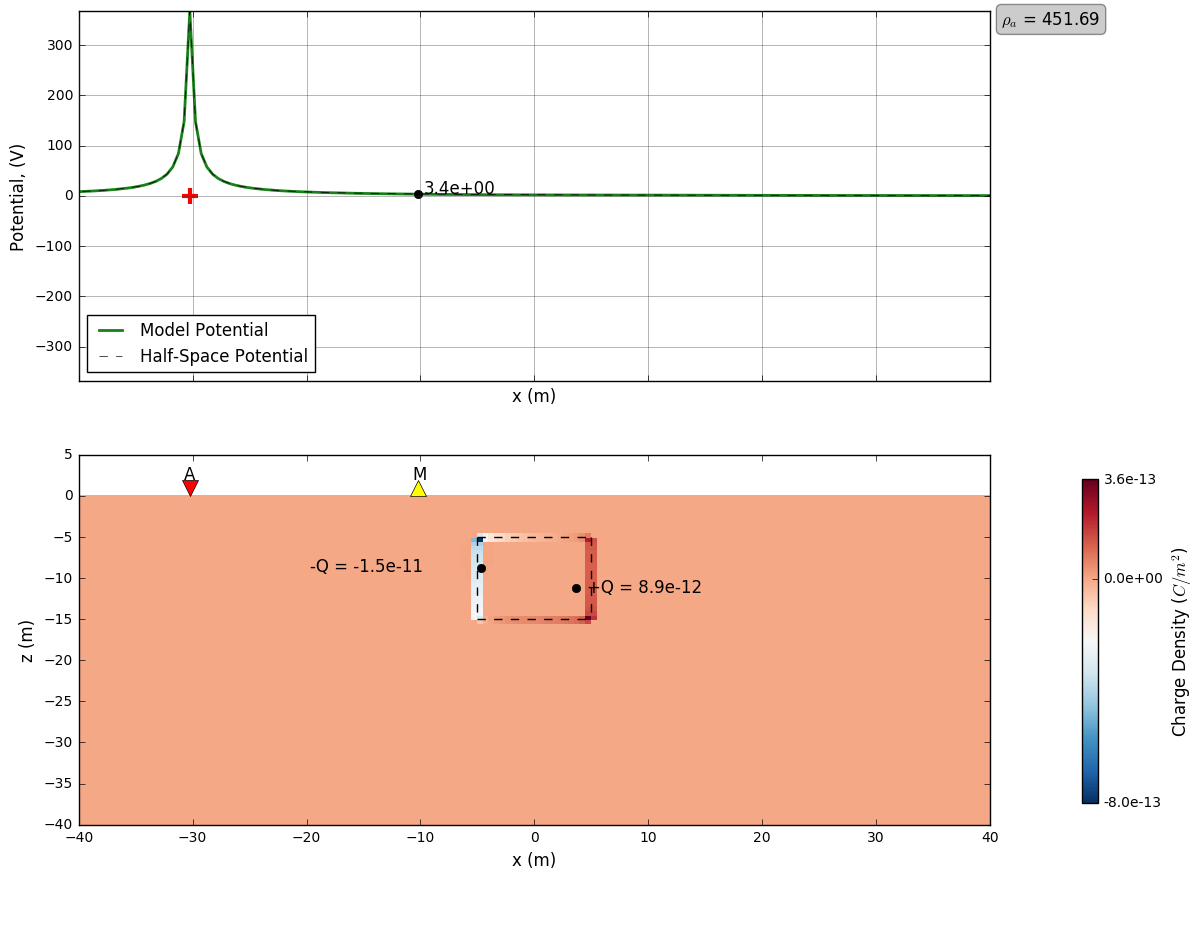

In [2]:
app = plate_app();
app

# Note: Sensitivity calculations will not work at this time since we have not set up the field object for the 2.5D 
# forumation.